Neste notebook, realizei um modelo que prevê crimes contra a propriedade em Nova York com base em 3 características da população, assassinatos e roubos.

Importando e limpando os dados

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [4]:
df_raw = pd.read_excel('table2.xls')


Como você pode ver aqui, temos algumas linhas extras na parte superior e precisamos rotular as colunas de acordo com a linha 3, que fornece os cabeçalhos das colunas.

In [5]:
# Mostrar as 5 ultimas linhas e também as 3 que precisam ser removidas
df_raw.tail()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
350,Yonkers,199134,1036,6,NaN,25,390,615,2368,470,1662,236,10
351,Yorktown Town,36643,15,0,NaN,0,2,13,334,45,287,2,NaN
352,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,3 The FBI does not publish arson data unless i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As últimas linhas aqui precisam ser excluídas, pois não contêm dados. Também precisamos verificar se há valores ausentes ou NaN nos dados.

In [6]:
# definindo o cabeçalho apropriado da 4ª linha de dados brutos

headers = df_raw.iloc[3]

# excluindo as linhas de 1 a 4 (ou linhas 0, 1, 2, 3)

df_ny = pd.DataFrame(df_raw.values[4:], columns=headers)

# renomeando as colunas

df_ny.columns = ['city', 'pop', 'vc', 'murder', 'rape1', 'rape2', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3']
df_ny_all = df_ny


# deletando colunas desnecessarias

df_ny = df_ny.drop(['vc', 'rape1', 'rape2', 'aa', 'burglary', 'lt', 'mvt', 'arson3'], axis=1)

# deletando algumas outras colunas

df_ny_some = df_ny_all.drop(['vc', 'rape1', 'rape2', 'lt', 'mvt', 'arson3'], axis=1)


# removendo as ultimas 3 linhas
df_ny = df_ny.drop([348, 349, 350], axis=0)

In [7]:
df_ny.head()

,city,pop,murder,robbery,pc
0,Adams Village,1861,0,0,12
1,Addison Town and Village,2577,0,0,24
2,Akron Village,2846,0,0,16
3,Albany,97956,8,227,4090
4,Albion Village,6388,0,4,223


In [8]:
#convertendo valores de string para float e criando coluna 'pop2' que é pop ao quadrado

df_ny["pop"] = [np.float(x) for x in df_ny["pop"]]
df_ny["pop2"] = [np.float(x*x) for x in df_ny["pop"]]
df_ny["murder"] = [np.float(x) for x in df_ny["murder"]]
df_ny["robbery"] = [np.float(x) for x in df_ny["robbery"]]
df_ny["pc"] = [np.float(x) for x in df_ny["pc"]]

C:\Users\PAULOF~1\AppData\Local\Temp/ipykernel_12172/4017869491.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_ny["pop"] = [np.float(x) for x in df_ny["pop"]]
C:\Users\PAULOF~1\AppData\Local\Temp/ipykernel_12172/4017869491.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_ny["pop2"] = [np.float(x*x) for x in df_ny["pop"]]
C:\

In [9]:
df_ny.dtypes

city        object
pop        float64
murder     float64
robbery    float64
pc         float64
pop2       float64
dtype: object

In [10]:
# Se assassinatos ou roubos forem maiores que 0, converta para 1 senão deixe em 0

df_ny['murder'] = df_ny['murder'].apply(lambda x : 1 if x>0 else 0)
df_ny['robbery'] = df_ny['robbery'].apply(lambda x : 1 if x>0 else 0)
df_ny.head()

,city,pop,murder,robbery,pc,pop2
0,Adams Village,1861.000,0,0,12.000,3463321.000
1,Addison Town and Village,2577.000,0,0,24.000,6640929.000
2,Akron Village,2846.000,0,0,16.000,8099716.000
3,Albany,97956.000,1,1,4090.000,9595377936.000
4,Albion Village,6388.000,0,1,223.000,40806544.000


In [11]:
df_ny.isnull().sum()

city       0
pop        0
murder     0
robbery    0
pc         0
pop2       0
dtype: int64

Agora vamos apenas olhar para o crime de propriedade versus população com um gráfico de dispersão.

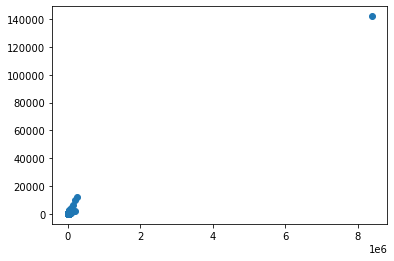

In [14]:
plt.scatter(df_ny['pop'], df_ny['pc'])

Parece que temos um enorme ponto fora da curva aqui que pode facilmente causar problemas na construção de um modelo confiável. Vamos descobrir o que é e remove-lo.

In [15]:
print(min(df_ny['pop']))
print(max(df_ny['pc']))
print(df_ny.loc[df_ny['city'] == 'New York'])
print('\n')
print(df_ny.loc[df_ny['pop'] == 526.0])

526.0
141971.0
         city         pop  murder  robbery         pc               pop2
216  New York 8396126.000       1        1 141971.000 70494931807876.000


                  city     pop  murder  robbery    pc       pop2
118  Glen Park Village 526.000       0        0 5.000 276676.000


Portanto, a cidade em questão é a cidade de Nova York, que tem uma população de 141.971.

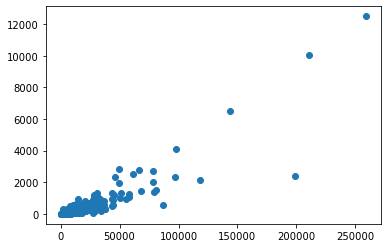

In [18]:
# deletando a linha 216
df_no_nyc = df_ny.drop([216])

# plotando de novo o gráfico
plt.scatter(df_no_nyc['pop'], df_no_nyc['pc'])

Bem melhor !

In [19]:
df_ny_all.tail()

,city,pop,vc,murder,rape1,rape2,robbery,aa,pc,burglary,lt,mvt,arson3
346,Yonkers,199134,1036,6,NaN,25,390,615,2368,470,1662,236,10
347,Yorktown Town,36643,15,0,NaN,0,2,13,334,45,287,2,NaN
348,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,3 The FBI does not publish arson data unless i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_ny_all = df_ny_all.drop(['rape1', 'arson3'], axis=1)

# deletando as ultimas 3 linhas
df_ny_all = df_ny_all.drop([348, 349, 350], axis=0)

df_ny_all.isnull().sum()

df_ny_all.head()

,city,pop,vc,murder,rape2,robbery,aa,pc,burglary,lt,mvt
0,Adams Village,1861,0,0,0,0,0,12,2,10,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1
2,Akron Village,2846,3,0,0,0,3,16,1,15,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142
4,Albion Village,6388,23,0,3,4,16,223,53,165,5


In [21]:
#convertendo valores de string para float e criando coluna 'pop2' que é pop ao quadrado

df_ny_all["pop"] = [np.float(x) for x in df_ny_all["pop"]]
df_ny_all["pop2"] = [np.float(x*x) for x in df_ny_all["pop"]]
df_ny_all["vc"] = [np.float(x) for x in df_ny_all["vc"]]
df_ny_all["murder"] = [np.float(x) for x in df_ny_all["murder"]]
df_ny_all["rape2"] = [np.float(x) for x in df_ny_all["rape2"]]
df_ny_all["robbery"] = [np.float(x) for x in df_ny_all["robbery"]]
df_ny_all["aa"] = [np.float(x) for x in df_ny_all["aa"]]
df_ny_all["pc"] = [np.float(x) for x in df_ny_all["pc"]]
df_ny_all["burglary"] = [np.float(x) for x in df_ny_all["burglary"]]
df_ny_all["lt"] = [np.float(x) for x in df_ny_all["lt"]]
df_ny_all["mvt"] = [np.float(x) for x in df_ny_all["mvt"]]


C:\Users\PAULOF~1\AppData\Local\Temp/ipykernel_12172/434584022.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_ny_all["pop"] = [np.float(x) for x in df_ny_all["pop"]]
C:\Users\PAULOF~1\AppData\Local\Temp/ipykernel_12172/434584022.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_ny_all["pop2"] = [np.float(x*x) for x in df_ny_a

<AxesSubplot:>

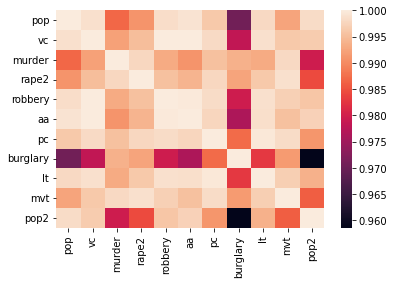

In [22]:
# Calcula a correlação pairwise de colunas, excluindo valores NA/null (com .corr); em seguida, crie o mapa de calor.
sns.heatmap(df_ny_all.corr())


Este é o mapa de calor com dados de NYC. Tudo é extremamente altamente correlacionado (provavelmente overfit). Também podemos ver que pop e pop2 estão praticamente perfeitamente correlacionados, então podemos descartar pop2.

In [23]:
df_ny_all_no_nyc = df_ny_all.drop([216])

<AxesSubplot:>

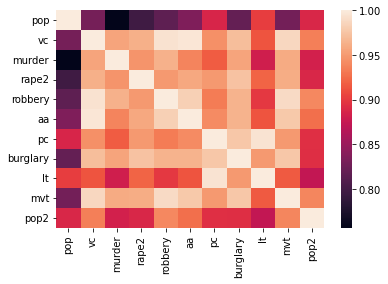

In [24]:
# Calcula a correlação pairwise de colunas, excluindo valores NA/null (com .corr); em seguida, crie o mapa de calor.

sns.heatmap(df_ny_all_no_nyc.corr())


Este mapa de calor deixa de fora os dados de NYC. Podemos ver a forte correlação positiva entre população (pop) e crimes contra a propriedade (pc), que se parece com cerca de 0,90. Além disso, vemos que o modelo não parece ser superajustado, pois as correlações chegam a 0,75. Parece que agressão agravada (aa) é o recurso menos correlacionado aqui, então talvez esse recurso seja o melhor para usar na próxima vez para construir um modelo melhor.

In [25]:
df_ny_all.head()

,city,pop,vc,murder,rape2,robbery,aa,pc,burglary,lt,mvt,pop2
0,Adams Village,1861.000,0.000,0.000,0.000,0.000,0.000,12.000,2.000,10.000,0.000,3463321.000
1,Addison Town and Village,2577.000,3.000,0.000,0.000,0.000,3.000,24.000,3.000,20.000,1.000,6640929.000
2,Akron Village,2846.000,3.000,0.000,0.000,0.000,3.000,16.000,1.000,15.000,0.000,8099716.000
3,Albany,97956.000,791.000,8.000,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,9595377936.000
4,Albion Village,6388.000,23.000,0.000,3.000,4.000,16.000,223.000,53.000,165.000,5.000,40806544.000


In [26]:
df_ny_some.head()

,city,pop,murder,robbery,aa,pc,burglary
0,Adams Village,1861,0,0,0,12,2
1,Addison Town and Village,2577,0,0,3,24,3
2,Akron Village,2846,0,0,3,16,1
3,Albany,97956,8,227,526,4090,705
4,Albion Village,6388,0,4,16,223,53


In [27]:
#convertendo valores de string para float e criando coluna 'pop2' que é pop ao quadrado

df_ny_some["pop"] = [np.float(x) for x in df_ny_some["pop"]]
df_ny_some["pop2"] = [np.float(x*x) for x in df_ny_some["pop"]]
df_ny_some["murder"] = [np.float(x) for x in df_ny_some["murder"]]
df_ny_some["robbery"] = [np.float(x) for x in df_ny_some["robbery"]]
df_ny_some["aa"] = [np.float(x) for x in df_ny_some["aa"]]
df_ny_some["pc"] = [np.float(x) for x in df_ny_some["pc"]]
df_ny_some["burglary"] = [np.float(x) for x in df_ny_some["burglary"]]


C:\Users\PAULOF~1\AppData\Local\Temp/ipykernel_12172/4197353811.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_ny_some["pop"] = [np.float(x) for x in df_ny_some["pop"]]
C:\Users\PAULOF~1\AppData\Local\Temp/ipykernel_12172/4197353811.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_ny_some["pop2"] = [np.float(x*x) for x in df

In [28]:
df_ny_some.head()

,city,pop,murder,robbery,aa,pc,burglary,pop2
0,Adams Village,1861.000,0.000,0.000,0.000,12.000,2.000,3463321.000
1,Addison Town and Village,2577.000,0.000,0.000,3.000,24.000,3.000,6640929.000
2,Akron Village,2846.000,0.000,0.000,3.000,16.000,1.000,8099716.000
3,Albany,97956.000,8.000,227.000,526.000,4090.000,705.000,9595377936.000
4,Albion Village,6388.000,0.000,4.000,16.000,223.000,53.000,40806544.000


In [29]:
df_ny_some.dtypes

city         object
pop         float64
murder      float64
robbery     float64
aa          float64
pc          float64
burglary    float64
pop2        float64
dtype: object

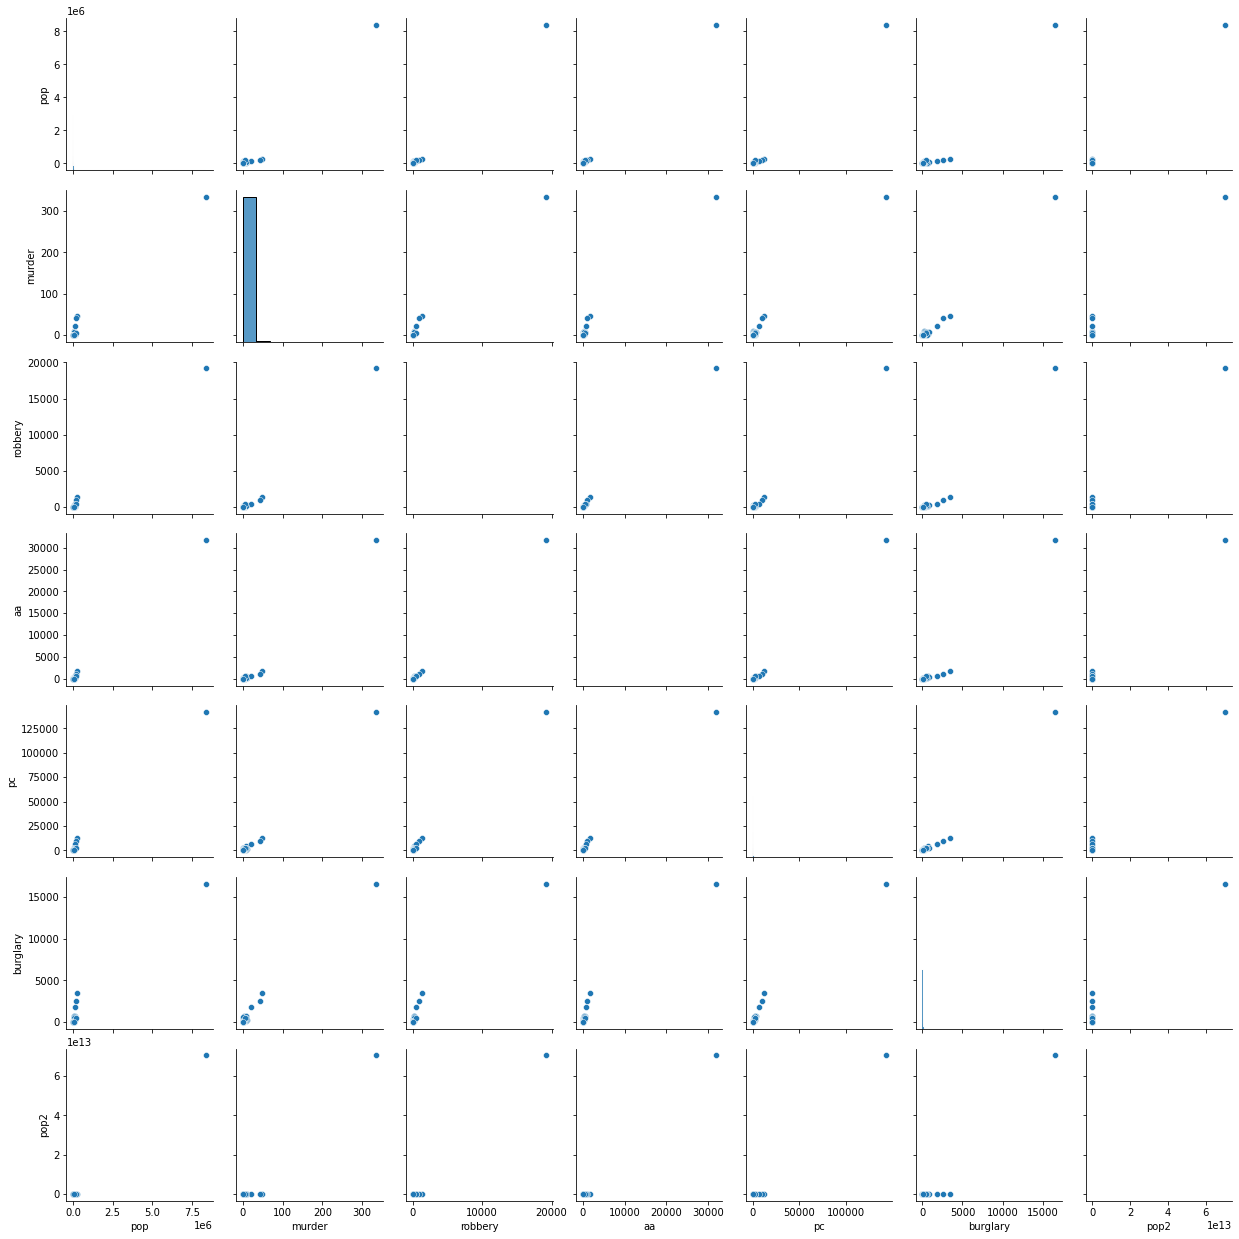

In [30]:
sns.pairplot(df_ny_some)

The above pairplot still includes NYC data which is not very helpful; it's too much of an outlier.  We have to drop NYC data.  Some features were dropped in order to read the pairplot better in accordance with the heatmap results.

In [205]:
# deletando nyc data
df_ny_some_no_nyc = df_ny_some.drop([216])

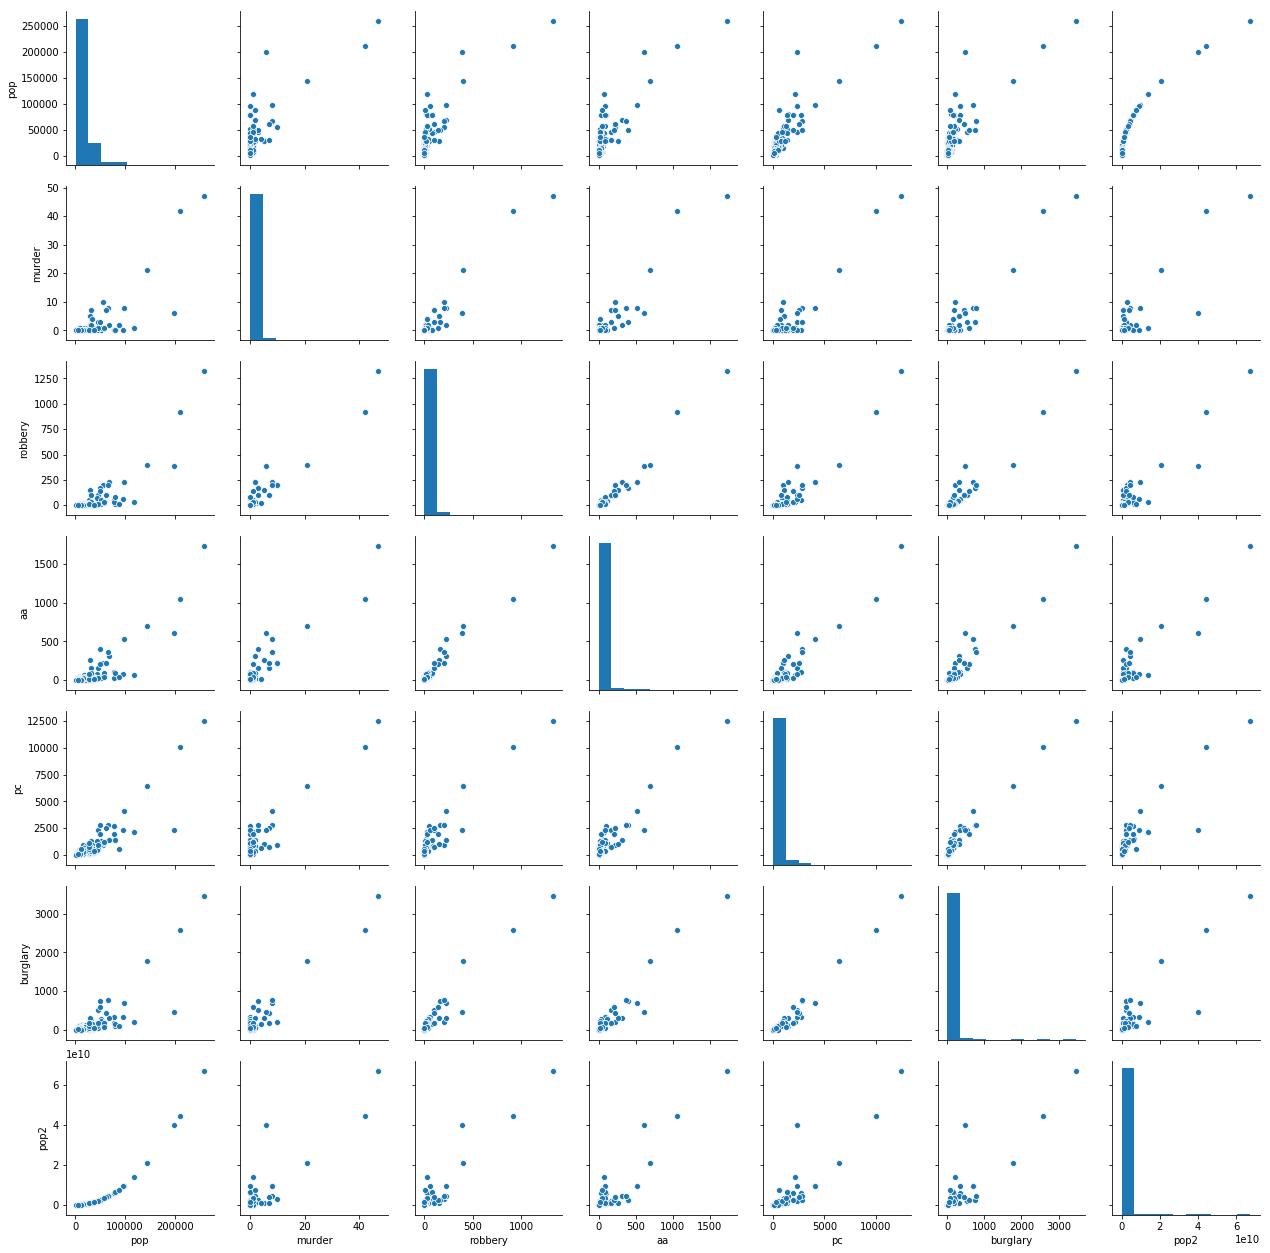

In [207]:
sns.pairplot(df_ny_some_no_nyc)

Construindo o nosso modelo

Sem fazer nada com os dados originais (dados com NYC), construa uma equação de regressão multivariável usando 'pop', 'assassinato' e 'roubo' para os recursos, ou variáveis independentes, para prever o crime contra a propriedade ('pc').

In [31]:
# Instanciando e treinando nosso modelo
regr = linear_model.LinearRegression()
Y = df_ny['pc'].values.reshape(-1, 1)
X = df_ny[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Vendo os resultados
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.68728222e-02 6.07383740e+02 1.06994709e+02]]

Intercept: 
 [-32.72226824]

R-squared:
0.9934485435725701


Então a equação seria: y = -32,7 + 0,017(pop) + 607(assassinato) + 107(roubo)

O valor de R ao quadrado é muito próximo de 1, o que pode significar que provavelmente superajustamos os dados.

Além disso, a população da cidade em questão precisa ser de pelo menos 1.924, caso contrário, o modelo preverá um valor negativo para ocorrências de crimes contra a propriedade, o que é impossível

Agora, vamos construir um modelo que exclua NYC.

In [32]:
# Instanciando e treinando nosso modelo
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc']
X = df_no_nyc[['pop','murder','robbery']]
regr.fit(X, Y)

# Vendo os resultados
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]

Intercept: 
 -108.42335403478944

R-squared:
0.7889428000907828


Agora, a equação se parece com: y = -108 + 0,034(pop) + 14,3(assassinato) - 94,3(roubo)

O novo valor de R ao quadrado é: 0,79

Isso é provavelmente mais desejável e um modelo melhor e uma boa equação de linha de base para construir. Devemos estar cientes de que a população precisa ser de pelo menos 3177, caso contrário, o crime patrimonial é negativo, o que é impossível.

Como próximo passo, vamos apenas construir um modelo simples que usa apenas o recurso de população para prever crimes contra a propriedade com e sem dados de Nova York. Primeiro, vamos construí-lo com os dados de NYC incluídos.

Coefficients: 
 [[0.01695663]]
Intercept: 
 [113.70298213]


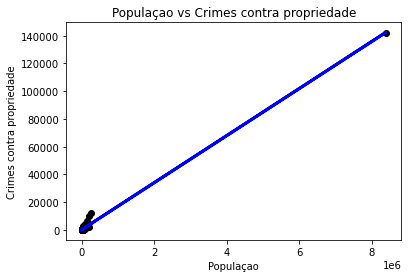

In [33]:
y = df_ny['pc'].values.reshape(-1, 1)
x = df_ny['pop'].values.reshape(-1, 1)

# Instanciando e treinando nosso modelo
regr = linear_model.LinearRegression()

# Ajustar nosso modelo aos nossos dados
regr.fit(x, y)

# Mostra os atributos que calculamos
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

# Plotando os resultados
plt.scatter(x, y, color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('Populaçao vs Crimes contra propriedade')
plt.xlabel('Populaçao')
plt.ylabel('Crimes contra propriedade')
plt.show()

Portanto, a equação simples seria: **y = 113,7 + 0,017(pop)**

Isso pode não ser tão ruim. Como você pode ver, não há valores de população (assumindo que seja pelo menos 0) onde o crime contra a propriedade seria previsto como um número negativo. Em seguida, vamos construir o modelo de regressão linear simples excluindo os dados de NYC.

Coefficients: 
 [[0.03389004]]
Intercept: 
 [-155.02048926]


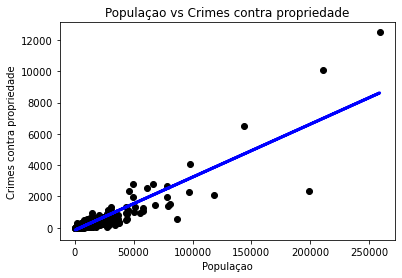

In [34]:
y = df_no_nyc['pc'].values.reshape(-1, 1)
x = df_no_nyc['pop'].values.reshape(-1, 1)

# Instanciando nosso modelo
regr = linear_model.LinearRegression()

# Ajustar nosso modelo aos nossos dados
regr.fit(x, y)

# Mostra os atributos que calculamos
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

# Plotando os resultados
plt.scatter(x, y, color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('Populaçao vs Crimes contra propriedade')
plt.xlabel('Populaçao')
plt.ylabel('Crimes contra propriedade')
plt.show()

Portanto, a nova equação, excluindo os dados de Nova York, seria: y = -155 + 0,034(pop)

A população, neste caso, deve ser de pelo menos 4559 para gerar uma previsão positiva de crimes contra a propriedade.


Avaliando o modelo

O erro de um modelo multivariável (calculado pela subtração dos valores previstos pelo modelo dos valores reais do resultado) deve ser distribuído normalmente. Vamos verificar se esse é o caso de nossos 2 modelos, nos quais usamos 3 recursos para prever o resultado. Primeiro, verificaremos o modelo com os dados de NYC incluídos.


Coefficients: 
 [[1.68728222e-02 6.07383740e+02 1.06994709e+02]]

Intercept: 
 [-32.72226824]

R-squared:
0.9934485435725701


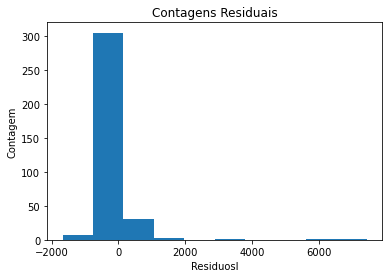

In [36]:
# Instanciando nosso modelo
regr = linear_model.LinearRegression()
Y = df_ny['pc'].values.reshape(-1, 1)
X = df_ny[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Olhando os resultados
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extraindo os valores previstos
predicted = regr.predict(X).ravel()
actual = df_ny['pc']

# Calcule o erro, também chamado de residual
residual = actual - predicted

# Criando o histograma.
plt.hist(residual)
plt.title('Contagens Residuais')
plt.xlabel('Residuosl')
plt.ylabel('Contagem')
plt.show()

Aqui podemos ver que os dados residuais são distribuídos normalmente; no entanto, é ligeiramente inclinado para a direita. Em seguida, vamos ver a distribuição residual após descartar os dados de NYC.


Coefficients: 
 [[ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]]

Intercept: 
 [-108.42335403]

R-squared:
0.7889428000907828


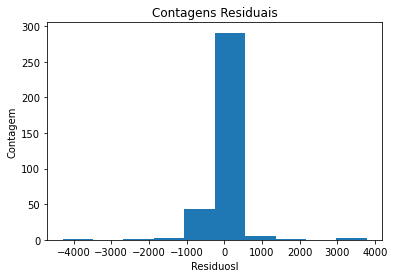

In [37]:
# Instanciando nosso modelo
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc'].values.reshape(-1, 1)
X = df_no_nyc[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Olhando os resultados
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extraindo os valores previstos
predicted = regr.predict(X).ravel()
actual = df_no_nyc['pc']

# Calcule o erro, também chamado de residual
residual = actual - predicted

# Criando o histograma.
plt.hist(residual)
plt.title('Contagens Residuais')
plt.xlabel('Residuosl')
plt.ylabel('Contagem')
plt.show()

Isso é muito, muito melhor. É mais normalmente distribuído e, portanto, muito mais útil para fins de previsão.

Como último passo, vejamos os gráficos de dispersão dos dados com NYC e sem NYC.


Coefficients: 
 [[1.68728222e-02 6.07383740e+02 1.06994709e+02]]

Intercept: 
 [-32.72226824]

R-squared:
0.9934485435725701


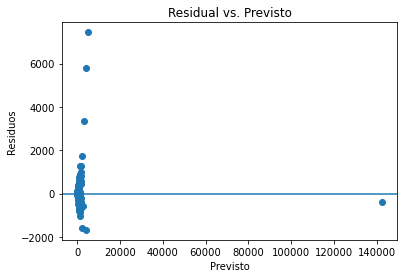

In [39]:
# Instanciando nosso modelo
regr = linear_model.LinearRegression()
Y = df_ny['pc'].values.reshape(-1, 1)
X = df_ny[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Olhando os resultados
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extraindo os valores previstos
predicted = regr.predict(X).ravel()
actual = df_ny['pc']

# Calcule o erro, também chamado de residual
residual = actual - predicted

# criando um  scatterplot
plt.scatter(predicted, residual)
plt.xlabel('Previsto')
plt.ylabel('Residuos')
plt.axhline(y=0)
plt.title('Residual vs. Previsto')
plt.show()

Como esperado, temos um problema significativo de heteroscedasticidade. Os dados de Nova York são os culpados. Em seguida, vamos ver o gráfico sem os dados de NYC.


Coefficients: 
 [[ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]]

Intercept: 
 [-108.42335403]

R-squared:
0.7889428000907828


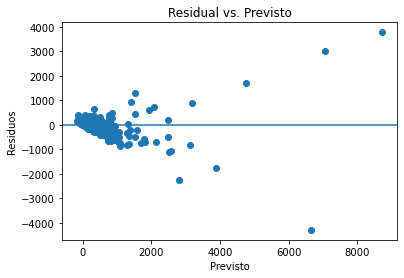

In [40]:
# Instanciando nosso modelo
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc'].values.reshape(-1, 1)
X = df_no_nyc[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Olhando os resultados
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extraindo os valores previstos
predicted = regr.predict(X).ravel()
actual = df_no_nyc['pc']

# Calcule o erro, também chamado de residual
residual = actual - predicted

# criando um scatterplot
plt.scatter(predicted, residual)
plt.xlabel('Previsto')
plt.ylabel('Residuos')
plt.axhline(y=0)
plt.title('Residual vs. Previsto')
plt.show()

Isso é muito mais homoscedástico. No entanto, é um pouco em forma de cone à medida que os valores previstos se tornam maiores, então pode valer a pena procurar maneiras de reduzir isso para pesquisas futuras.

Conclusao

A principal descoberta deste estudo para prever crimes contra a propriedade com as entradas de população, assassinato e roubo é que o outlier - neste caso NYC - superajusta significativamente o modelo e reduz significativamente a eficácia deste modelo se o usarmos para prever propriedades criminalidade em outros estados. A solução óbvia seria remover os dados de NYC, o que fizemos, a fim de construir um modelo mais robusto e versátil para previsões futuras.

Às vezes, um modelo muito simples com apenas uma variável de entrada pode ser melhor do que usar várias entradas. Mostramos que simplesmente usar a população como uma única entrada pode produzir um modelo inicialmente eficaz, mas aqui, novamente, provavelmente é sensato omitir os dados de Nova York porque eles sobrecarregam todos os outros dados.

É importante conhecer os objetivos e usos futuros do modelo e neste exercício não recebemos essas explicações. Para a futura construção e validação do modelo, precisamos considerar o propósito do modelo para testar os resultados/previsões de forma mais eficaz.
